In [1]:
import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.fftpack import fft
from scipy.special import gamma
import matplotlib.pyplot as plt
import math
import neurokit2 as nk
import scipy
import scipy.signal
import scipy.special
import neurokit2 as nk
import pywt
from scipy.special import gamma
from joblib import dump, load
import pickle


In [2]:
#hermf(WinLen, dim, supp)
def hermf(N, M, tm):
    dt = 2 * tm / (N - 1)
    tt = np.linspace(-tm, tm, N)
    P = np.zeros((M + 1, N))
    Htemp = np.zeros((M + 1, N))
    Dh = np.zeros((M, N))
    g = np.exp(-tt**2 / 2)

    P[0, :] = np.ones(N)
    P[1, :] = 2 * tt

    for k in range(2, M + 1):
        P[k, :] = 2 * tt * P[k - 1, :] - 2 * (k - 2) * P[k - 2, :]

    for k in range(M + 1):
        Htemp[k, :] = P[k, :] * g / np.sqrt(np.sqrt(np.pi) * 2**(k - 1) * gamma(k+1)) * np.sqrt(dt)

    h = Htemp[0:M,:]

    for k in range(M):
        Dh[k, :] = (tt * Htemp[k, :] - np.sqrt(2 * (k)) * Htemp[k + 1, :]) * dt

    return h, Dh, tt

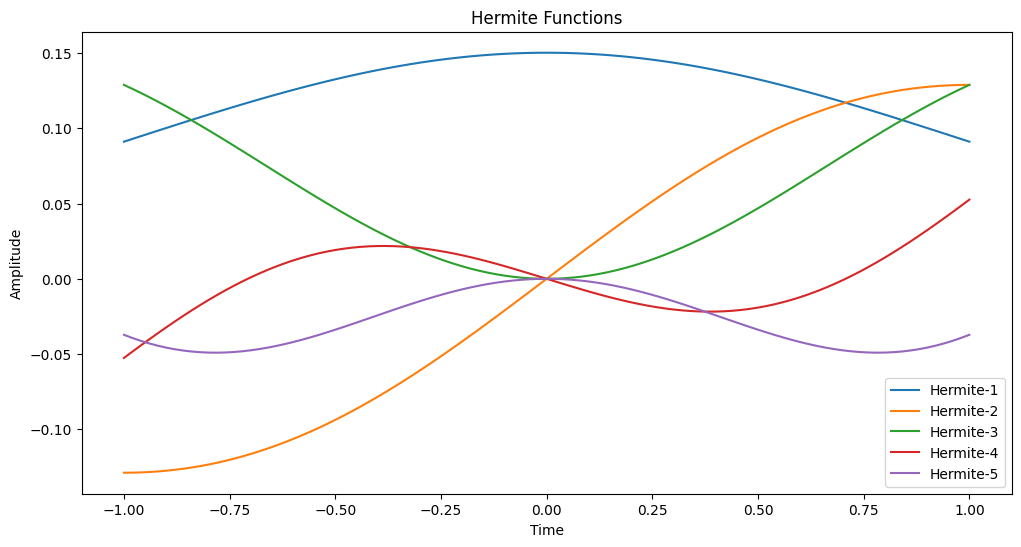

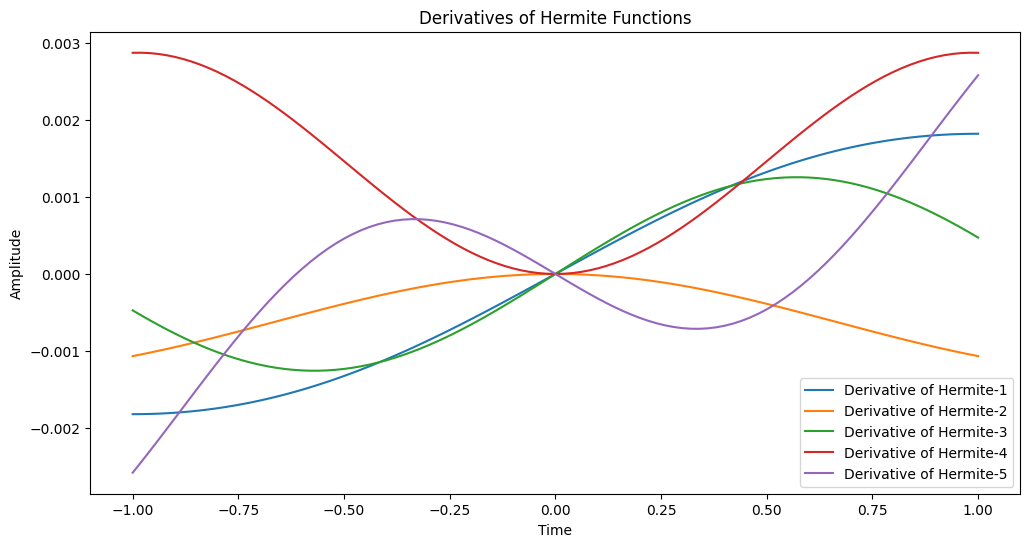

In [3]:
# Example parameters
N = 101  # Number of points (must be odd)
M = 5    # Maximum order
tm = 1   # Half time support

# Call the hermf function
h , Dh , tt = hermf(101, 5, 1)

# Plot the Hermite functions and their derivatives
plt.figure(figsize=(12, 6))
for i in range(M):
    plt.plot(tt, h[i], label=f'Hermite-{i + 1}')

plt.title('Hermite Functions')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()

# Plot the derivatives of the Hermite functions
plt.figure(figsize=(12, 6))
for i in range(M):
    plt.plot(tt, Dh[i], label=f'Derivative of Hermite-{i + 1}')

plt.title('Derivatives of Hermite Functions')
plt.xlabel('Time')
plt.ylabel('Amplitude')
plt.legend()
plt.show()



In [4]:

def SST_STFT(x, lowFreq, highFreq, alpha, h=None, Dh=None, tDS=1, Smooth=True, Hemi=True):
    
    xrow = x.size
    x = np.squeeze(x)


    t = np.arange(x.size)
    tLen = t[::tDS].size
    
        # for tfr 
    N = np.arange(-0.5+alpha,0.5, alpha).size +1

    Nrange= int(N/2)
    
        # for tfrsq
    Lidx = np.round((N / 2) * (lowFreq / 0.5)) 
    Hidx = np.round((N / 2) * (highFreq / 0.5))-1 #TODO

    fLen = int(Hidx - Lidx + 1)
    
    
    
    #====================================================================
    ## check input signals
    if highFreq > 0.5:
        print('TopFreq must be a value in [0, 0.5]')
        return
    elif (tDS < 1) or (np.remainder(tDS,1)!=0):
        print('tDS must be an integer value >= 1')
        return

    h = h.T
    hrow=len(h)
    hcol=1
    h = np.squeeze(h)
    Dh = Dh.T
    Dh = np.squeeze(Dh)

    Lh = (hrow-1)/2
    if (hcol!=1)or (np.remainder(hrow,2)==0):
        print('H must be a smoothing window with odd length')
        return
    

    #====================================================================
        
    tfrtic = np.linspace(0, 0.5, N//2)
    tfrsqtic = np.linspace(lowFreq, highFreq, fLen)
    tfrsq = np.zeros([tfrsqtic.size, tLen], dtype='complex')
    tfr = np.zeros([tfrtic.size, tLen], dtype='complex')  # for h

    
    Ex = np.mean(np.abs(x) ** 2)
    Threshold = 1.0e-8*Ex  
    
    Mid = np.round(tfrsqtic.size/2).astype('int')
    Delta = 20*(tfrsqtic[2]-tfrsqtic[1])**2
    weight = np.exp(-(tfrsqtic[Mid-10:Mid+10]-tfrsqtic[Mid]) **2/Delta)
    weight = weight / sum(weight)
    weightIDX = np.arange(Mid-10,Mid+10+1)-Mid

    

    for tidx in np.arange(tLen):
    
        ti = t[(tidx-1)*tDS+1]+1
        A = -np.min(np.array([np.round(N/2)-1,Lh,ti-1]))
        B = np.min(np.array([np.round(N/2)-1, Lh, xrow-ti]))+1
        ti=ti-1
        tau = np.arange(A,B)
        tau = tau.astype('int')
        indices= np.remainder(N+tau,N)

        LhTau = (Lh+tau).astype('int')
        norm_h = np.linalg.norm(h[LhTau])

        
    
        tf0 = np.zeros(N)
        tf1 = np.zeros(N)
        tf0[indices] = x[ti+tau]* np.conj(h[LhTau])/norm_h 
        tf1[indices] = x[ti+tau]* np.conj(Dh[LhTau])/norm_h 

        
        tf0 = scipy.fftpack.fft(tf0)[np.arange(Nrange)]
        tf1 = scipy.fftpack.fft(tf1)[np.arange(Nrange)]

       
    
            # get the first order omega
        omega = np.zeros(tf1.size)


        avoid_warn = np.where(tf0!=0)
        omega[avoid_warn] = np.round(np.imag(N*tf1[avoid_warn]/tf0[avoid_warn]/(2.0*np.pi)))
        
    
   
        sst = np.zeros(fLen, dtype='complex')
    
        for jcol in range(np.round(N/2).astype('int')):
            if np.abs(tfr[jcol,0]) > Threshold:
                jcolhat = jcol - omega[jcol]

                
    
                if (jcolhat <= Hidx) & (jcolhat >= Lidx):
                        
                    if Smooth:
                        IDXb = np.array(np.where((jcolhat-Lidx+weightIDX <= Hidx) & (jcolhat-Lidx+weightIDX >= Lidx)))
                        IDXa = jcolhat-Lidx+weightIDX[IDXb]
                        IDXa=IDXa.astype(int)
    
    
                        if Hemi:
                            if np.real(tf0[jcol]) > 0:
                                sst[IDXa%len(sst)] = sst[IDXa%len(sst)] + tf0[jcol]*weight[IDXb%len(weight)]
                            else:
                                sst[IDXa%len(sst)] = sst[IDXa%len(sst)] - tf0[jcol]*weight[IDXb%len(weight)]                
                       
                        else:
                            sst[IDXa] = sst[IDXa] + tf0[jcol]*weight[IDXb]
    
                    else:
    
                        if Hemi:
                            if (np.real(tf0[jcol]) > 0):
                                sst[int(jcolhat-Lidx)] = sst[int(jcolhat-Lidx)] + tf0[jcol]
                            else:
                                sst[int(jcolhat-Lidx)] = sst[int(jcolhat-Lidx+1)] - tf0[jcol]
                        else:
                            sst[int(jcolhat-Lidx)] = sst[int(jcolhat-Lidx)] + tf0[jcol]
        tfr[:, tidx] = tf0
        tfrsq[:, tidx] = sst
    
    return tfr, tfrtic, tfrsq, tfrsqtic



In [5]:

def SST_STFT(x, lowFreq, highFreq, alpha, h=None, Dh=None, tDS=1, Smooth=True, Hemi=True):
    
    xrow = x.size
    x = np.squeeze(x)


    t = np.arange(x.size)
    tLen = t[::tDS].size
    
        # for tfr 
    N = np.arange(-0.5+alpha,0.5, alpha).size +1

    Nrange= int(N/2)
    
        # for tfrsq
    Lidx = np.round((N / 2) * (lowFreq / 0.5)) 
    Hidx = np.round((N / 2) * (highFreq / 0.5))-1 #TODO

    fLen = int(Hidx - Lidx + 1)
    
    
    
    #====================================================================
    ## check input signals
    if highFreq > 0.5:
        print('TopFreq must be a value in [0, 0.5]')
        return
    elif (tDS < 1) or (np.remainder(tDS,1)!=0):
        print('tDS must be an integer value >= 1')
        return

    h = h.T
    hrow=len(h)
    hcol=1
    h = np.squeeze(h)
    Dh = Dh.T
    Dh = np.squeeze(Dh)

    Lh = (hrow-1)/2
    if (hcol!=1)or (np.remainder(hrow,2)==0):
        print('H must be a smoothing window with odd length')
        return
    

    #====================================================================
        
    tfrtic = np.linspace(0, 0.5, N//2)
    tfrsqtic = np.linspace(lowFreq, highFreq, fLen)
    tfrsq = np.zeros([tfrsqtic.size, tLen], dtype='complex')
    tfr = np.zeros([tfrtic.size, tLen], dtype='complex')  # for h

    
    Ex = np.mean(np.abs(x) ** 2)
    Threshold = 1.0e-8*Ex  
    
    Mid = np.round(tfrsqtic.size/2).astype('int')
    Delta = 20*(tfrsqtic[2]-tfrsqtic[1])**2
    weight = np.exp(-(tfrsqtic[Mid-10:Mid+10]-tfrsqtic[Mid]) **2/Delta)
    weight = weight / sum(weight)
    weightIDX = np.arange(Mid-10,Mid+10+1)-Mid

    

    for tidx in np.arange(tLen):
    
        ti = t[(tidx-1)*tDS+1]+1
        A = -np.min(np.array([np.round(N/2)-1,Lh,ti-1]))
        B = np.min(np.array([np.round(N/2)-1, Lh, xrow-ti]))+1
        ti=ti-1
        tau = np.arange(A,B)
        tau = tau.astype('int')
        indices= np.remainder(N+tau,N)

        LhTau = (Lh+tau).astype('int')
        norm_h = np.linalg.norm(h[LhTau])

        
    
        tf0 = np.zeros(N)
        tf1 = np.zeros(N)
        tf0[indices] = x[ti+tau]* np.conj(h[LhTau])/norm_h 
        tf1[indices] = x[ti+tau]* np.conj(Dh[LhTau])/norm_h 

        
        tf0 = scipy.fftpack.fft(tf0)[np.arange(Nrange)]
        tf1 = scipy.fftpack.fft(tf1)[np.arange(Nrange)]

       
    
            # get the first order omega
        omega = np.zeros(tf1.size)


        avoid_warn = np.where(tf0!=0)
        omega[avoid_warn] = np.round(np.imag(N*tf1[avoid_warn]/tf0[avoid_warn]/(2.0*np.pi)))
        
    
   
        sst = np.zeros(fLen, dtype='complex')
    
        for jcol in range(np.round(N/2).astype('int')):
            if np.abs(tfr[jcol,0]) > Threshold:
                jcolhat = jcol - omega[jcol]

                
    
                if (jcolhat <= Hidx) & (jcolhat >= Lidx):
                        
                    if Smooth:
                        IDXb = np.array(np.where((jcolhat-Lidx+weightIDX <= Hidx) & (jcolhat-Lidx+weightIDX >= Lidx)))
                        IDXa = jcolhat-Lidx+weightIDX[IDXb]
                        IDXa=IDXa.astype(int)
    
    
                        if Hemi:
                            if np.real(tf0[jcol]) > 0:
                                sst[IDXa%len(sst)] = sst[IDXa%len(sst)] + tf0[jcol]*weight[IDXb%len(weight)]
                            else:
                                sst[IDXa%len(sst)] = sst[IDXa%len(sst)] - tf0[jcol]*weight[IDXb%len(weight)]                
                       
                        else:
                            sst[IDXa] = sst[IDXa] + tf0[jcol]*weight[IDXb]
    
                    else:
    
                        if Hemi:
                            if (np.real(tf0[jcol]) > 0):
                                sst[int(jcolhat-Lidx)] = sst[int(jcolhat-Lidx)] + tf0[jcol]
                            else:
                                sst[int(jcolhat-Lidx)] = sst[int(jcolhat-Lidx+1)] - tf0[jcol]
                        else:
                            sst[int(jcolhat-Lidx)] = sst[int(jcolhat-Lidx)] + tf0[jcol]
        tfr[:, tidx] = tf0
        tfrsq[:, tidx] = sst
    
    return tfr, tfrtic, tfrsq, tfrsqtic



In [6]:
import numpy as np
from numpy import savetxt
import matplotlib.pyplot as plt

import scipy
from scipy import stats
from scipy import signal
from scipy.stats import norm
from scipy.stats import pearsonr
import scipy.io as sio
import scipy.special


from sklearn.metrics import pairwise_distances
import matplotlib.pyplot as plt
import pandas as pd
from glob import glob

import cripser  #pip install -U git+https://github.com/shizuo-kaji/CubicalRipser_3dim
from ripser import ripser  #pip install Ripser
from persim import plot_diagrams

import os
import mne
import pyedflib

import neurokit2 as nk
import math



import numpy as np
import pandas as pd
from scipy.interpolate import interp1d
from scipy.fftpack import fft
from scipy.special import gamma
import matplotlib.pyplot as plt
import math
import scipy
import scipy.signal
import scipy.special
import neurokit2 as nk
import pywt


import neurokit2 as nk  #pip install neurokit2

from dtw import *

import math

import time

import pyedflib
from pyedflib import highlevel


In [7]:
signal, signal_headers, header = highlevel.read_edf(r"D:\Hau-Tieng\CPAP\(CPAP)20130103-21397137-1185-CGMHLinKou\A0001185.edf")

data = pyedflib.EdfReader(r"D:\Hau-Tieng\CPAP\(CPAP)20130103-21397137-1185-CGMHLinKou\A0001185.edf")


In [8]:
signal_labels = data.getSignalLabels()
print(f"Signal Labels: {signal_labels}")


Signal Labels: ['EEG C3-A2', 'EEG O1-A2', 'EEG O2-A1', 'EOG Left', 'EOG Right', 'EMG Chin', 'ECG I', 'RR', 'ECG II', 'Snore', 'SpO2', 'Flow Patient', 'Pleth', 'Leg RLEG', 'Leg LLEG', 'TidVol', 'EEG C4-A1', 'EEG A1-A2', 'Effort Tho', 'Effort Abd', 'Body', 'xPAP CPAP', 'Leak Total', 'Flow Patient', 'Imp']


In [9]:
cpap_signal = data.readSignal(signal_labels.index('xPAP CPAP'))
flow_signal = data.readSignal(signal_labels.index('Flow Patient'))


In [11]:
cpap_signal_array = np.array(cpap_signal)
flow_signal_array=np.array(flow_signal)

np.shape(flow_signal_array)

(5109800,)

In [12]:

# Desired length of each epoch (sub-array)
epoch_length = 6000

# Number of complete epochs that can be formed
num_complete_epochs = len(flow_signal_array) // epoch_length

# Truncate the signal to have a length that is a multiple of epoch_length
truncated_signal = flow_signal_array[:num_complete_epochs * epoch_length]

# Reshape the signal into epochs (list of sub-arrays)
epochs = np.split(truncated_signal, num_complete_epochs)

# Display the result
print(np.shape(epochs))




(851, 6000)


In [14]:
hh=h[0]
Dhh=Dh[0]
X_stft_181 = []
counter = 0
num_ts_per_subject = []
ts1=epochs 
num_ts, len_ts = np.shape(ts1)
ts1 = ts1/np.mean(np.abs(ts1))
num_ts_per_subject.append( num_ts )
for j in range(0,num_ts-1):
        Zx, ff1, Zxx, ff2= SST_STFT(ts1[j,:-1], 0, 0.5, 0.001, hh, Dhh, 200, True, True)
        X_stft_181.append( Zxx )

In [ ]:
np.save("X_stft_181.npy",X_stft_181)

In [15]:
df = pd.read_csv(r"D:\Hau-Tieng\CPAP\(CPAP)20130103-21397137-1185-CGMHLinKou\STAGE.csv")

df_selected = df.iloc[1::,0:2]

bdf=df_selected.iloc[1::30, :].reset_index(drop=True)

bd1=np.array(bdf)[:,1]
#np.min([np.shape(bd1)[0],np.shape(epochs)[0]] )




In [ ]:
np.save("bd1.npy",bd1)